In [ ]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from nltk import download
download('stopwords')
download('wordnet')
from nltk.corpus import stopwords
import tensorflow
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
from gensim.models.fasttext import FastText

pd.set_option("display.max_colwidth", -1)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/data

/content/drive/MyDrive/Colab Notebooks/data


In [ ]:
data=pd.read_csv("abstract_summary.csv")

In [ ]:
data.dropna(axis=0,inplace=True) #dropping na

In [ ]:
all_stopwords = stopwords.words('english')

def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    newString = re.sub(r"'s\b","",newString)
    text_tokens = newString.split()
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    newString = " ".join(tokens_without_sw)
    newString = re.sub(r"\s+"," ",newString)
    
    return newString

In [ ]:
#call the function
cleaned_text = [text_cleaner(t) for t in data['Text']]
cleaned_summary = [text_cleaner(t) for t in data['Summary']]

data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary

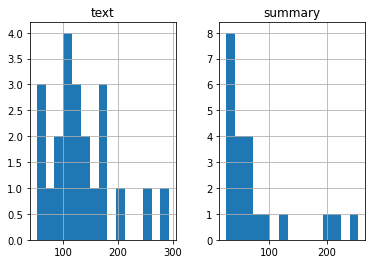

In [ ]:
# distribution of sequences
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_summary:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'summary': summary_word_count})
length_df.hist(bins=15)
plt.show()

In [ ]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=250):
        count += 1
print(count/len(cleaned_text))

0.9090909090909091


In [ ]:
count = 0
for i in cleaned_summary:
    if(len(i.split())<=120):
        count += 1
print(count/len(cleaned_summary))

0.8181818181818182


In [ ]:
max_summary_len = 120
max_text_len = 250

cleaned_text = np.array(cleaned_text)
cleaned_summary = np.array(cleaned_summary)

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text, 'summary':short_summary})

Text:

In [ ]:
# define dummy data and precproces them
docs = short_text

# train fasttext from gensim api
ft = FastText(size=10, window=2, min_count=1, seed=33)
ft.build_vocab(docs)
ft.train(docs, total_examples=ft.corpus_count, epochs=10)

In [ ]:
# prepare text for keras neural network
MAX_LEN = 120

tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(lower=True)
tokenizer.fit_on_texts(docs)

sequence_docs = tokenizer.texts_to_sequences(docs)
sequence_docs = tensorflow.keras.preprocessing.sequence.pad_sequences(sequence_docs, maxlen=MAX_LEN)

# extract fasttext learned embedding and put them in a numpy array
embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, ft.vector_size))

In [ ]:
sequence_docs

array([[   0,    0,    0, ...,   30,  396,  397],
       [   0,    0,    0, ...,   57,  221,  212],
       [   0,    0,    0, ...,   41,   33,  138],
       ...,
       [  74,    1,  191, ...,  932,  120,    1],
       [ 367,   12,    1, ...,  186,  969,  970],
       [ 369,  994,    8, ..., 1034, 1035, 1036]], dtype=int32)

In [ ]:
pas = 0
for word,i in tokenizer.word_index.items():
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1

HIDDEN_UNITS = 32

Summary:

In [ ]:
# define dummy data and precproces them
docs2 = short_summary

# train fasttext from gensim api
ft2 = FastText(size=10, window=2, min_count=1, seed=33)
ft2.build_vocab(docs2)
ft2.train(docs2, total_examples=ft2.corpus_count, epochs=10)

In [ ]:
tokenizer2 = tensorflow.keras.preprocessing.text.Tokenizer(lower=True)
tokenizer2.fit_on_texts(docs2)

sequence_docs2 = tokenizer2.texts_to_sequences(docs2)
sequence_docs2 = tensorflow.keras.preprocessing.sequence.pad_sequences(sequence_docs2, maxlen=MAX_LEN)

# extract fasttext learned embedding and put them in a numpy array
embedding_matrix_ft2 = np.random.random((len(tokenizer2.word_index) + 1, ft2.vector_size))

In [ ]:
len(tokenizer2.word_index)

506

In [ ]:
pas2 = 0
for word,i in tokenizer2.word_index.items():
    try:
        embedding_matrix_ft2[i] = ft2.wv[word]
    except:
        pas2 += 1

HIDDEN_UNITS = 32

Corpus:

In [ ]:
corpus = short_text + short_summary
len(corpus)

34

In [ ]:
# train fasttext from gensim api
ft3 = FastText(size=10, window=3, min_count=1, seed=33)
ft3.build_vocab(corpus)
ft3.train(corpus, total_examples=ft2.corpus_count, epochs=10)

tokenizer3 = tensorflow.keras.preprocessing.text.Tokenizer(lower=True)
tokenizer3.fit_on_texts(corpus)

# text
sequence_text = tokenizer3.texts_to_sequences(corpus)
sequence_text = tensorflow.keras.preprocessing.sequence.pad_sequences(sequence_text, maxlen=MAX_LEN)

# summary
sequence_summary = tokenizer3.texts_to_sequences(corpus)
sequence_summary = tensorflow.keras.preprocessing.sequence.pad_sequences(sequence_summary, maxlen=MAX_LEN)

# extract fasttext learned embedding and put them in a numpy array
embedding_matrix_ft3 = np.random.random((len(tokenizer3.word_index) + 1, ft3.vector_size))

pas3 = 0
for word,i in tokenizer3.word_index.items():
    try:
        embedding_matrix_ft3[i] = ft3.wv[word]
    except:
        pas3 += 1

HIDDEN_UNITS = 32

Model:

In [ ]:
# define a keras model and load the pretrained fasttext weights matrix
encoder_inputs = Input(shape=(MAX_LEN,))

# embedding layer
enc_emb = Embedding(len(tokenizer3.word_index) + 1, ft.vector_size, 
                weights=[embedding_matrix_ft3], trainable=False)(encoder_inputs)

# encoder lstm 1
encoder_lstm1 = LSTM(HIDDEN_UNITS, return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder lstm 2
encoder_lstm2 = LSTM(HIDDEN_UNITS, return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder lstm 3
encoder_lstm3 = LSTM(HIDDEN_UNITS, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(MAX_LEN,))

# embedding layer
dec_emb = Embedding(len(tokenizer3.word_index) + 1, ft2.vector_size, 
                weights=[embedding_matrix_ft3], trainable=False)(decoder_inputs)

decoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True,dropout=0.3,recurrent_dropout=0.1)
decoder_outputs1, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention layer
attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([encoder_outputs, decoder_outputs1])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs1, attn_out])

# dense layer
decoder_dense =  TimeDistributed(Dense(len(tokenizer3.word_index) + 1, activation='softmax'))
decoder_outputs2 = decoder_dense(decoder_concat_input)

# Define the model 
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs2)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 120, 10)      11980       input_15[0][0]                   
__________________________________________________________________________________________________
lstm_28 (LSTM)                  [(None, 120, 32), (N 5504        embedding_14[0][0]               
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 120)]        0                                            
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
"""es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2), 
      ModelCheckpoint('./MyModel_tf',monitor='val_loss', verbose=1,
                      save_best_only=True, mode='min', save_weights_only = False)]"""

"es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2), \n      ModelCheckpoint('./MyModel_tf',monitor='val_loss', verbose=1,\n                      save_best_only=True, mode='min', save_weights_only = False)]"

In [ ]:
model.fit([sequence_text, sequence_summary], sequence_summary,
          batch_size=16,
          epochs=50,
          validation_split=0.2)

Epoch 1/50
2/2 [==============================] - 12s 2s/step - loss: 7.0682 - accuracy: 0.0012 - val_loss: 7.0426 - val_accuracy: 0.0036
Epoch 2/50
2/2 [==============================] - 1s 613ms/step - loss: 7.0662 - accuracy: 0.0012 - val_loss: 7.0388 - val_accuracy: 0.0036
Epoch 3/50
2/2 [==============================] - 1s 591ms/step - loss: 7.0625 - accuracy: 0.0015 - val_loss: 7.0348 - val_accuracy: 0.0036
Epoch 4/50
2/2 [==============================] - 1s 590ms/step - loss: 7.0605 - accuracy: 0.0028 - val_loss: 7.0309 - val_accuracy: 0.0048
Epoch 5/50
2/2 [==============================] - 1s 638ms/step - loss: 7.0576 - accuracy: 0.0025 - val_loss: 7.0269 - val_accuracy: 0.0048
Epoch 6/50
2/2 [==============================] - 1s 584ms/step - loss: 7.0551 - accuracy: 0.0025 - val_loss: 7.0229 - val_accuracy: 0.0048
Epoch 7/50
2/2 [==============================] - 1s 582ms/step - loss: 7.0526 - accuracy: 0.0031 - val_loss: 7.0188 - val_accuracy: 0.0048
Epoch 8/50
2/2 [======

In [ ]:
# Save model
model.save('myAttentionSeq2seq_125.h5')

In [ ]:
pred = model.predict([sequence_text[0], sequence_summary[0]])
pred

array([[[0.00090695, 0.00087093, 0.00086491, ..., 0.00079503,
         0.00079808, 0.00082482]],

       [[0.00090695, 0.00087093, 0.00086491, ..., 0.00079503,
         0.00079808, 0.00082482]],

       [[0.00090695, 0.00087093, 0.00086491, ..., 0.00079503,
         0.00079808, 0.00082482]],

       ...,

       [[0.00093567, 0.00087686, 0.00088251, ..., 0.00076209,
         0.00077493, 0.00082434]],

       [[0.00094849, 0.00088099, 0.00087884, ..., 0.00076659,
         0.00078043, 0.00083117]],

       [[0.00092717, 0.00087626, 0.00087345, ..., 0.00077441,
         0.00078738, 0.00083236]]], dtype=float32)

In [ ]:
reverse_word_index = dict(
    (i, word) for word, i in tokenizer3.word_index.items())

In [ ]:
def prediction_text(some_text):
  pred_text = tokenizer3.texts_to_sequences(text_cleaner(some_text))
  pred_text = tensorflow.keras.preprocessing.sequence.pad_sequences(pred_text, maxlen=MAX_LEN)

  pred_seq = model.predict([pred_text, pred_text])

  t = ""
  for p in pred_seq:
    t += reverse_word_index[np.argmax(p[0]) + 1] + " "

  return t

In [ ]:
short_text[0]

'summarythis case report describes year old woman presented bilateral femoral stress fractures osteoporosis years excessive levothyroxine treatment bone health restored rapidly long lasting reduction levothyroxine dosage bone active treatment warranted introductionhyperthyroidism known risk factor osteoporosis fractures recent studies patients serum thyrotropin suppressive therapy however indicated adverse effects bone long term follow case report describes long term follow data clinically euthyreoid patient developed symptomatic osteoporosis due excessive levothyroxine treatment correction levothyroxine dosage bone mineral density previously elevated serum osteocalcin levels normalized rapidly remained free fractures years follow menopause conclusionexcessive tsh suppression contributed secondary osteoporosis patient bmd normalized dose reduction levothyroxine fractures occurred years follow patients develop severe osteoporosis substituted levothyroxine decent follow patients levothyr

In [ ]:
pred = model.predict([sequence_text[2], sequence_summary[2]])

In [ ]:
t = ""
for p in pred:
  t += reverse_word_index[np.argmax(p[0]) + 1] + " "

t

'months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months months osteoporosis second osteoporosis second patients months patients months months months second patients months patients months patients patients second osteoporosis months months patients patients osteoporosis osteoporosis patients osteoporosis second months patients patients second osteoporosis second patients osteoporosis second osteoporosis patients osteoporosis months months osteoporosis patients months patients months second osteoporosis months patients patients months osteoporosis patients second months months patients second months osteoporosis patients months months second months patients osteoporosis second patients osteoporosis patients second months '